# Topic Modeling arXiv Abstracts

<a href="https://github.com/MaartenGr/BERTopic"><img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="20%" height="20%" align="right" /></a>

In this notebook, we will go through applying advanced topic modeling techniques with [BERTopic](https://github.com/MaartenGr/BERTopic). Topic modeling is a technique that allows users to generate insights into large amount of textual data without the need to read them individually. 

However, more than just looking at the generated topics, we want to understand topic relations, how they evolved over time, and how we can improve topic representations. The true strength of topic modeling is looking beyond merely generating topics and using them to truly understand the relationships and patterns in the data. 

The great thing about using these Arxiv abstracts is that the text is typically well-structured and nicely written. For BERT-based embedding models this allows the document representations to be a bit more accurate than what we would normally see. 

### Install BERTopic

In [2]:
%%capture
!pip install bertopic

**NOTE**: After installing BERTopic, make sure to restart the notebook to re-import the correct versions of packages that were previously imported. 

## Prepare Data
We start by extracting all abstracts between 2000 and 2021, their titles and the years in which they were published.

In [3]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) 

In [4]:
import json

# https://arxiv.org/help/api/user-manual
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

data_file = '../input/arxiv/arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line
            
titles = []
abstracts = []
years = []
categories = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(ref[-4:]) 
        if 2000 < year <= 2021:
            categories.append(category_map[paper_dict.get('categories').split(" ")[0]])
            years.append(year)
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
    except:
        pass 

len(titles), len(abstracts), len(years), len(categories)

(149082, 149082, 149082, 149082)

In [9]:
print(type(abstracts))
print(abstracts[0])

<class 'list'>
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.



## Train Topic Model
Next, we train our BERTopic model using just a few changes to the default parameters. 

Starting off is the embedding model. The string `"paraphrase-MiniLM-L6-v2"` references the embedding model that can be found [here](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) and is a great sentence-transformer model that balances performance with speed. 

Next, we make sure that the minimum topic size of our topics is 50. We do this to limit the number of topics that could be generated. For example, if the minimum were to be 10 then much more topics could be generated that are most likely to be of little interest. Since we want large topics, we set it to 50. 

In [11]:
from bertopic import BERTopic

topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(abstracts)
len(topic_model.get_topic_info())

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/631 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/4659 [00:00<?, ?it/s]

2022-09-09 02:35:26,224 - BERTopic - Transformed documents to Embeddings
2022-09-09 02:38:05,817 - BERTopic - Reduced dimensionality
2022-09-09 02:38:25,916 - BERTopic - Clustered reduced embeddings


185

**NOTE**: BERTopic is stochastic since it uses UMAP as one of its dependencies so the results may differ between runs. 

## Topic Representation

We can see that roughly 200 topics were generated from our topics. Next, let's see what the major topics are:



In [14]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,70643,-1_the_of_in_and
1,0,6219,0_higgs_boson_dark_matter
2,1,4769,1_branes_theory_string_brane
3,2,4704,2_mathbb_prove_mathcal_algebras
4,3,3545,3_quark_pi_qcd_chiral
...,...,...,...
180,179,53,179_vehicle_driving_traffic_autonomous
181,180,51,180_stars_star_radial_velocity
182,181,51,181_ads_cft_bulk_boundary
183,182,50,182_comet_comets_cometary_coma


In [15]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,70643,-1_the_of_in_and
1,0,6219,0_higgs_boson_dark_matter
2,1,4769,1_branes_theory_string_brane
3,2,4704,2_mathbb_prove_mathcal_algebras
4,3,3545,3_quark_pi_qcd_chiral
5,4,2884,4_dark_universe_cosmological_energy
6,5,2110,5_graphene_materials_electronic_magnetic
7,6,1989,6_neutrino_neutrinos_oscillation_oscillations
8,7,1866,7_pi_pm_branching_decays
9,8,1678,8_flow_fluid_water_turbulence


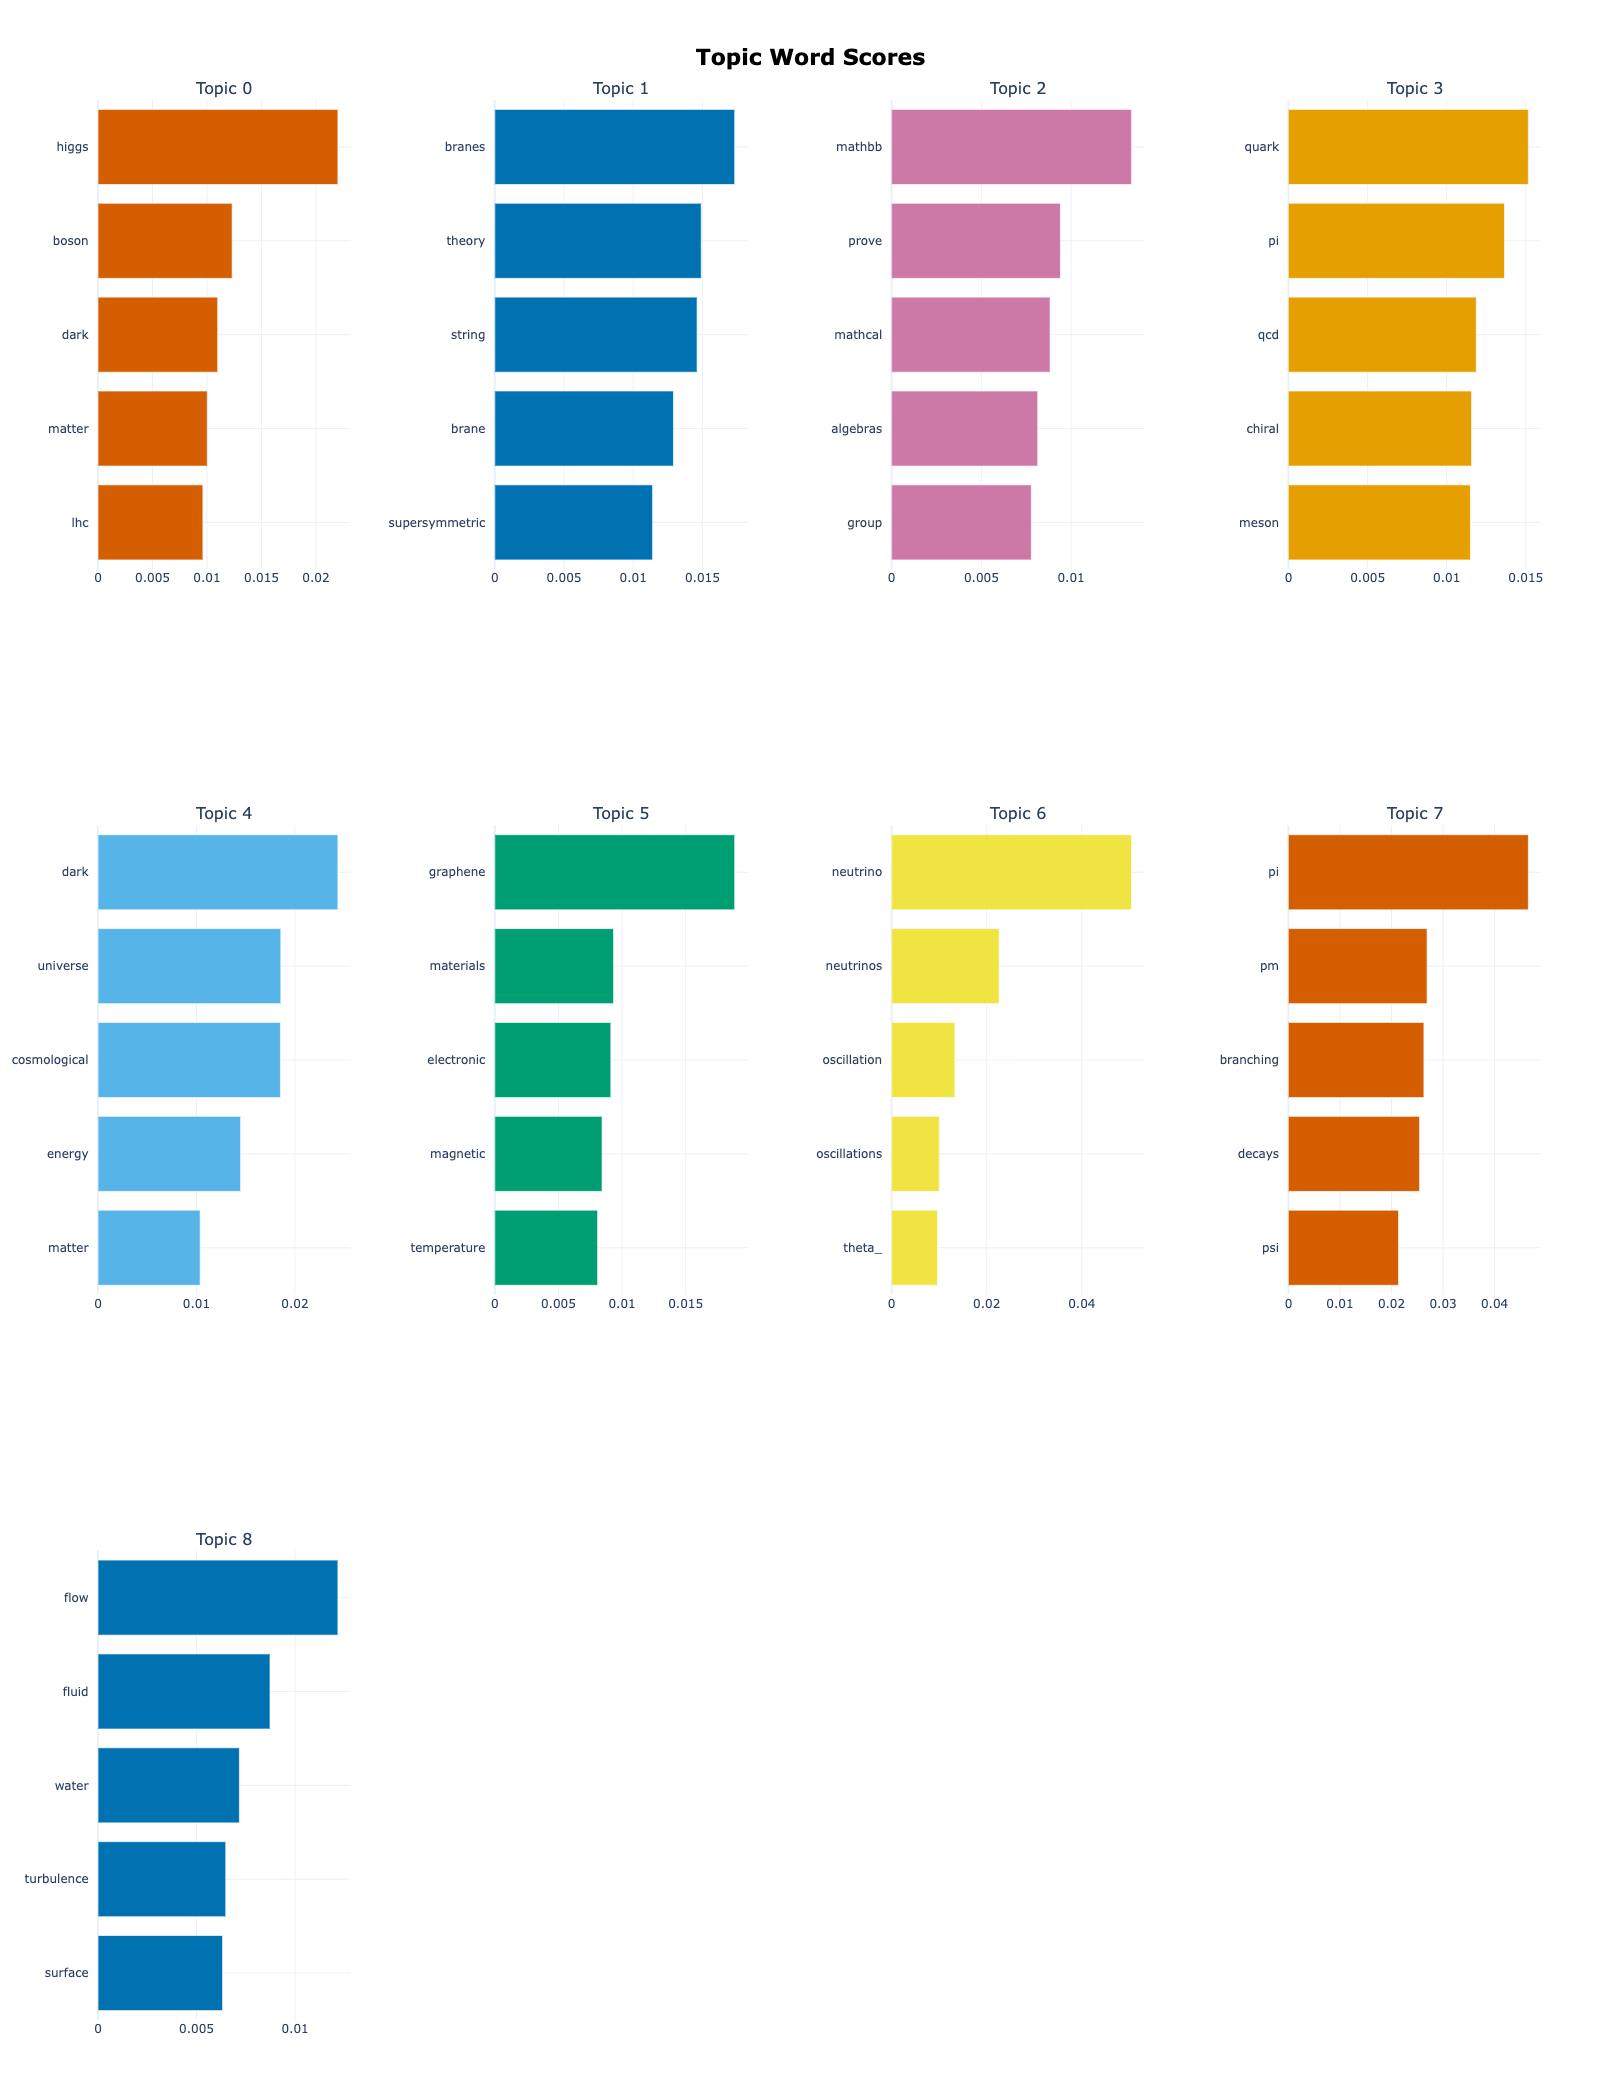

In [16]:
topic_model.visualize_barchart(top_n_topics=9, height=700)

From a glance, the most frequent topics seem to have coherent and clear topic representations. Interpretation of these clusters is much easier if you are familiar with the content of the documents. For example, to me, Topic 6 seems to be clearly about anything Data Science and AI.

For each topic, we have generated 10 words that best represent that topic. However, are 10 words sufficient? Can we already have a good topic representation with 1 word? 

To understand the amount of words needed to have a sufficient topic representation, we can show the decline of term score when adding terms. The idea here is that each term that is added has a lower term score than the previous since the first is the best term for the topic. Eventually, we reach the point of diminishing returns, which is very similar to the elbow-method used in k-NN. Below, you can see the decline in term score when adding terms per topic:

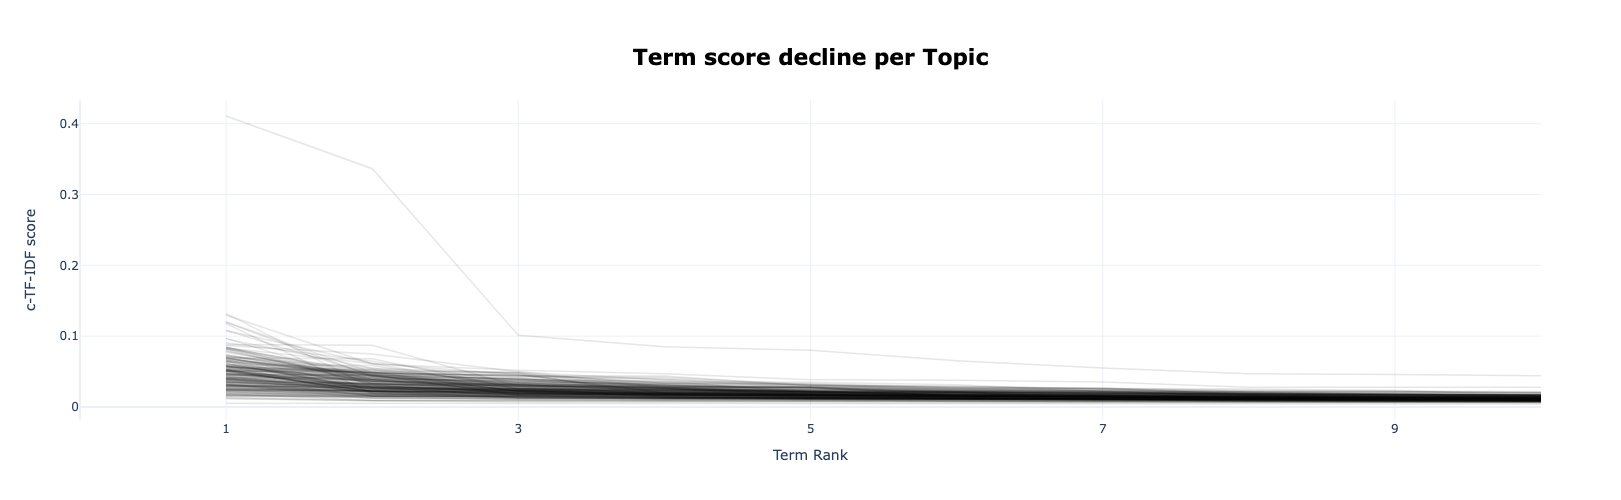

In [17]:
topic_model.visualize_term_rank()

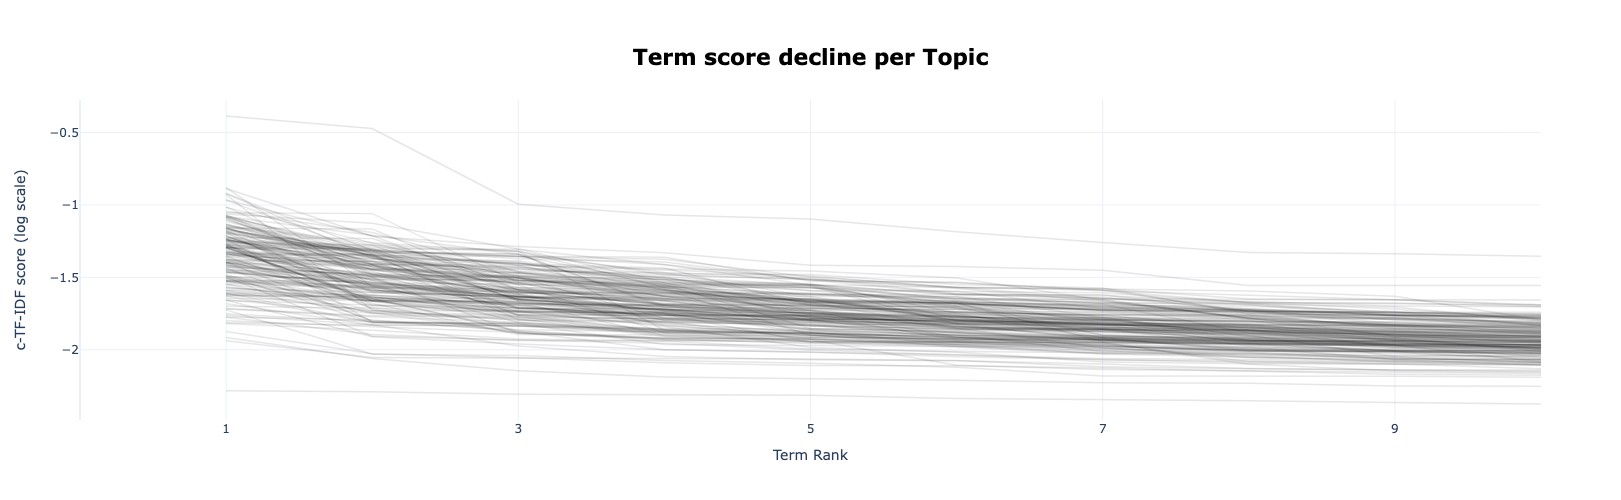

In [18]:
topic_model.visualize_term_rank(log_scale=True)

Using the elbow method, it seems that 3 words per topic are sufficient in representing the topic well. Any words that we add after that have seemingly little effect. 

**NOTE**: All visualizations are created with Plotly and are as such interactive!

## Topic Relationships
Having extracted the topics and their representations it might be helpful to check out the uniqueness of each topic. Some topics might be quite similar and could be merged or are simply interesting to research further. 

To do this, we start off by mapping our topics to a 2D representation by reducing the topic vectors with UMAP:

In [ ]:
topic_model.visualize_topics(top_n_topics=50)

The distance between topics show, to a certain extend, the similarities between topics. However, to better visualize and understand the similarity between topics, we can use two plots to gives us further insight into that. Namely, visualizing the possible topic hierarchy and its similarity matrix:

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50, width=800)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, top_n_topics=100)

The blocky structure in the heatmap shows that there are some clusters of topics to be found that are somewhat similar to each other. Zooming into these topics helps us understand why they are similar. If you hover over the topics, you can see the topic ID and representation. 

## Topics over Time
Although extracting the topics and their representation is interesting, we are missing some dimensional information. For example, some topics might not be relevant anymore or some are gaining traction over the last years. That can be vital information when making decisions. 

Here, we will model the topics over the years. For each topic and timestep, we calculate the c-TF-IDF representation. This will result in a specific topic representation at each timestep without the need to create clusters from embeddings as they were already created. However, topics can be regarded as evolutionary entities that evolve and change over time. This means that a topic representation at timestep *t* should be related to its representation at timesetps *t-1* and *t+1*. To model this evolutionary trend, we average its c-TF-IDF representation with that of the c-TF-IDF representation at timestep *t-1*. This is done for each topic representation allowing for the representations to evolve over time.

In [ ]:
topics_over_time = topic_model.topics_over_time(abstracts, topics, years)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20, width=900, height=500)

From the visualization above, we can see some interesting patterns appearing. Namely, around 2012 a lot of topics seem to become less and less frequent with several topics taking over. For example, topics 2 and 3 seem to be popular until 2012 after which its popularity decreased significantly. 

## Topics per Class
Lastly, let's focus on the given categories for each paper. Can we find out which topics are frequently found in certain categories? Typically, topic modeling tends to find more topics than the categories that were previously defined. This helps us find and understand certain subcategories that might exist in the data. 

In [ ]:
topics_per_class = topic_model.topics_per_class(abstracts, topics, classes=categories)

In [ ]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, width=900)